In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits
import matplotlib.mlab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Calculating Average Price

Read the data for latitude, longitutde, price, and weekly price while removing the "$" and "," so I can read the columns as floats instead of strings

In [7]:
data = pd.read_csv("./data/listings.csv")
data = data[['latitude','longitude', 'price', 'weekly_price']]
data['weekly_price'] = data['weekly_price'].str.replace('$', '').str.replace(',', '').astype(float)
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)
data.head(10)

/Users/simran/Desktop/virtual_env/capital-one/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.0
1,37.754166,-122.421534,220.0,1050.0
2,37.758506,-122.406152,100.0,NaN
3,37.756549,-122.422025,117.0,NaN
4,37.760051,-122.421352,200.0,NaN
5,37.759495,-122.424874,162.0,NaN
6,37.760997,-122.413124,230.0,1400.0
7,37.750543,-122.416559,173.0,NaN
8,37.756288,-122.408738,600.0,NaN
9,37.757246,-122.409315,250.0,NaN


Remove all rows that don't have a weekly price. I print out the length of the data without rows and I attempt to remove any more values that don't have a latitude, longitude, or regular price, but since the lengths are the same, that means the only NaNs exist in the weekly price.

In [8]:
has_weekly = data.dropna(subset=['weekly_price']);
print(len(has_weekly))
print(len(has_weekly.dropna(how='any')))
has_weekly.head()

2165
2165


,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.0
1,37.754166,-122.421534,220.0,1050.0
6,37.760997,-122.413124,230.0,1400.0
10,37.749329,-122.410792,300.0,1900.0
14,37.766521,-122.424660,95.0,550.0


I figure out on average how many times the price an owner gets for week as opposed to a day. I figured it was around 7, but it doesn't hurt to get a more accurate number. This is useful to make an educated guess as to what the weekly price of houses with just a price is.

In [9]:
avg_multiplier = (has_weekly.weekly_price/has_weekly.price).mean()
print(avg_multiplier)

6.73920600177


Replace all the NaN with the averge multiplier times the nightly price

In [10]:
data.weekly_price.fillna(data.price*avg_multiplier, inplace=True)
data.head()

,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.000000
1,37.754166,-122.421534,220.0,1050.000000
2,37.758506,-122.406152,100.0,673.920600
3,37.756549,-122.422025,117.0,788.487102
4,37.760051,-122.421352,200.0,1347.841200


Just some information that would be interesting to see.

In [11]:
data.describe()

,latitude,longitude,price,weekly_price
count,8706.000000,8706.000000,8706.000000,8706.000000
mean,37.767743,-122.430262,250.160579,1655.122398
std,0.021930,0.025466,474.630624,3169.221635
min,37.706928,-122.511500,0.000000,0.000000
25%,37.753321,-122.442043,100.000000,680.000000
50%,37.769819,-122.425420,160.000000,1050.000000
75%,37.785527,-122.412451,250.000000,1684.801500
max,37.831093,-122.364759,10000.000000,67392.060018


In [12]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

/Users/simran/Desktop/virtual_env/capital-one/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
data.head()

,latitude,longitude,price,weekly_price
0,37.754184,-122.406514,49.0,300.000000
1,37.754166,-122.421534,220.0,1050.000000
2,37.758506,-122.406152,100.0,673.920600
3,37.756549,-122.422025,117.0,788.487102
4,37.760051,-122.421352,200.0,1347.841200


Splitting the data into its features and labels

In [14]:
features = data[['latitude','longitude']]
labels = data[['weekly_price']]
x_train , x_test , y_train , y_test = train_test_split(features , labels , test_size = 0.20,random_state =2)

In [15]:
grid_num = len(features.latitude.values)
xi = np.linspace(features.latitude.min(), features.latitude.max(), num=grid_num)
yi = np.linspace(features.longitude.min(), features.longitude.max(), num=grid_num)
zi = matplotlib.mlab.griddata(features.latitude.values, features.longitude.values, labels.values.reshape(-1), xi, yi, interp='linear')

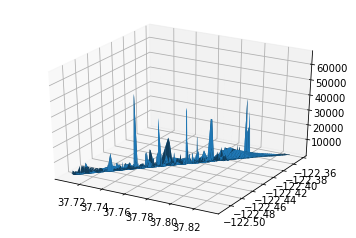

In [16]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xi, yi, zi)
plt.show()

# KNN Regressor

In [17]:
reg = KNeighborsRegressor(10)

A score of 0 is if we had just predicted the averages, so this is definitely not a great model

In [18]:
reg.fit(x_train,y_train)
reg.score(x_test,y_test)

-0.033150769897492438

Just looking at the values, to make sure everything has worked out. You can see even from these 10 that the model is not doing a very great job at predicting very high prices.

In [19]:
x_test.head(10)

,latitude,longitude
8325,37.720802,-122.463017
842,37.727048,-122.459462
4943,37.773238,-122.429438
4468,37.796564,-122.413304
5152,37.777702,-122.435590
2915,37.759797,-122.430435
2862,37.762749,-122.403750
3291,37.765173,-122.432329
4134,37.801473,-122.405711
8512,37.756212,-122.415546


In [20]:
y_test.head(10)

,weekly_price
8325,606.528540
842,10749.033573
4943,1010.880900
4468,2021.761801
5152,500.000000
2915,1078.272960
2862,1000.000000
3291,1475.886114
4134,599.789334
8512,673.920600


In [21]:
reg.predict(x_test[:10])

array([[ 1032.59730164],
       [  727.70089652],
       [ 1394.87174366],
       [ 1131.21680399],
       [ 1764.45053077],
       [ 1961.43824569],
       [ 2076.99874708],
       [ 1443.53514471],
       [ 2774.04018503],
       [ 1264.87087463]])

Curious to see that the mean is about the same as the actual dataset, but the standard deviation is much lower. This model doesn't really handle the information very well. This is also pretty apparent with the negative r squared value.

In [22]:
pd.DataFrame(reg.predict(x_test)).describe()

,0
count,1742.000000
mean,1637.366611
std,1023.712785
min,401.568935
25%,1115.304503
50%,1416.401532
75%,1847.105269
max,9009.664354


Saving the information of the model so that it can be used as a function in the actual web app

In [23]:
from sklearn.externals import joblib
joblib.dump(reg, 'KNNeighborsRegressor.pkl', protocol=2)

['KNNeighborsRegressor.pkl']

In [26]:
print(type(x_test))

<class 'pandas.core.frame.DataFrame'>


In [25]:
test = joblib.load('KNNeighborsRegressor.pkl') 
test.predict(x_test[:10])

array([[ 1032.59730164],
       [  727.70089652],
       [ 1394.87174366],
       [ 1131.21680399],
       [ 1764.45053077],
       [ 1961.43824569],
       [ 2076.99874708],
       [ 1443.53514471],
       [ 2774.04018503],
       [ 1264.87087463]])

# SVR

In [478]:
svr_reg = SVR()

In [479]:
svr_reg.fit(x_train,y_train)
svr_reg.score(x_test,y_test)

/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.029058923283726168

In [480]:
pd.DataFrame(svr_reg.predict(x_test)).describe()

,0
count,1742.000000
mean,1051.223342
std,0.563516
min,1049.505447
25%,1050.860471
50%,1051.225237
75%,1051.693124
max,1053.043035


# Gradient Boosting

In [500]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [545]:
GBR = GradientBoostingRegressor(n_estimators=2, max_depth=2, learning_rate=.12, random_state=3, max_features=1)
GBR.fit(x_train,y_train)
print(GBR.score(x_test,y_test))
pd.DataFrame(GBR.predict(x_test)).describe()

0.00185978161039


/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0
count,1742.000000
mean,1638.947889
std,51.279072
min,1536.741229
25%,1627.299308
50%,1627.299308
75%,1653.403538
max,1805.732553


In [561]:
from sklearn.grid_search import GridSearchCV
param_test = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(200,1001,200))};
grid_search = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5);
grid_search.fit(x_train,y_train);

/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/Simran/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x1069bb150, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Simra.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1069bb150, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Simra.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 7, 5, 7, 16, 668065, tzinfo=tzutc()), 'msg_id': '8E474C1DC8F940C6B939E07CBF317FC1', 'msg_type': 'execute_request', 'session': 'BF9F7FB9822741A6973EBC54E4FAE653', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '8E474C1DC8F940C6B939E07CBF317FC1', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'BF9F7FB9822741A6973EBC54E4FAE653']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 7, 5, 7, 16, 668065, tzinfo=tzutc()), 'msg_id': '8E474C1DC8F940C6B939E07CBF317FC1', 'msg_type': 'execute_request', 'session': 'BF9F7FB9822741A6973EBC54E4FAE653', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '8E474C1DC8F940C6B939E07CBF317FC1', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'BF9F7FB9822741A6973EBC54E4FAE653'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 7, 5, 7, 16, 668065, tzinfo=tzutc()), 'msg_id': '8E474C1DC8F940C6B939E07CBF317FC1', 'msg_type': 'execute_request', 'session': 'BF9F7FB9822741A6973EBC54E4FAE653', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '8E474C1DC8F940C6B939E07CBF317FC1', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.grid_search import GridSearchCV\npar...=False, cv=5);\ngrid_search.fit(x_train,y_train);\n', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-561-496ea7e886e7>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 116252128, execution_..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x135e9e930, file "<ipython-input-561-496ea7e886e7>", line 5>
        result = <ExecutionResult object at 116252128, execution_..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x135e9e930, file "<ipython-input-561-496ea7e886e7>", line 5>, result=<ExecutionResult object at 116252128, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x135e9e930, file "<ipython-input-561-496ea7e886e7>", line 5>
        self.user_global_ns = {'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0,
             verbose=0, warm_start=False), 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", 'data = pd.read_csv("/data/listings.csv")', 'data = pd.read_csv("/data/listings.csv")', 'data = pd.read_csv("//data/listings.csv")', 'data = pd.read_csv("./data/listings.csv")', 'data.head()', 'list(data)', "df1 = df[['latitue','longitutde']]", "data = data[['latitue','longitude']]", "data = data[['latitude','longitude']]", "data = data[['latitude','longitude', 'price', 'weekly_price']]", "data = data[['latitude','longitude', 'price', 'weekly_price']]", 'data = pd.read_csv("./data/listings.csv")', 'list(data)', "data = data['latitude','longitude', 'price', 'weekly_price']", "data = data[['latitude','longitude', 'price', 'weekly_price']]", ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {9:          id                            listing_u...8  
4                NaN  

[5 rows x 95 columns], 10: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', ...], 17: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', ...], 20:     latitude   longitude    price weekly_price
0...aN
4  37.760051 -122.421352  $200.00          NaN, 23:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 24:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 25:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 26:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 28:     latitude   longitude    price weekly_price
0...aN
4  37.760051 -122.421352  $200.00          NaN, 30:     latitude   longitude    price weekly_price
0...aN
4  37.760051 -122.421352  $200.00          NaN, ...}, 'RFR': RandomForestRegressor(bootstrap=True, criterion=...lse, random_state=3, verbose=0, warm_start=False), ...}
        self.user_ns = {'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0,
             verbose=0, warm_start=False), 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", "import numpy as np\nimport pandas as pd\nimport ma...toolkits\nget_ipython().magic('matplotlib inline')", 'data = pd.read_csv("/data/listings.csv")', 'data = pd.read_csv("/data/listings.csv")', 'data = pd.read_csv("//data/listings.csv")', 'data = pd.read_csv("./data/listings.csv")', 'data.head()', 'list(data)', "df1 = df[['latitue','longitutde']]", "data = data[['latitue','longitude']]", "data = data[['latitude','longitude']]", "data = data[['latitude','longitude', 'price', 'weekly_price']]", "data = data[['latitude','longitude', 'price', 'weekly_price']]", 'data = pd.read_csv("./data/listings.csv")', 'list(data)', "data = data['latitude','longitude', 'price', 'weekly_price']", "data = data[['latitude','longitude', 'price', 'weekly_price']]", ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {9:          id                            listing_u...8  
4                NaN  

[5 rows x 95 columns], 10: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', ...], 17: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', ...], 20:     latitude   longitude    price weekly_price
0...aN
4  37.760051 -122.421352  $200.00          NaN, 23:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 24:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 25:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 26:        latitude   longitude      price weekly_pr...    $100.00          NaN

[8706 rows x 4 columns], 28:     latitude   longitude    price weekly_price
0...aN
4  37.760051 -122.421352  $200.00          NaN, 30:     latitude   longitude    price weekly_price
0...aN
4  37.760051 -122.421352  $200.00          NaN, ...}, 'RFR': RandomForestRegressor(bootstrap=True, criterion=...lse, random_state=3, verbose=0, warm_start=False), ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/Simran/GitHub/Capital-One-Project/<ipython-input-561-496ea7e886e7> in <module>()
      1 from sklearn.grid_search import GridSearchCV
      2 param_test = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(200,1001,200))};
      3 grid_search = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
      4 param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5);
----> 5 grid_search.fit(x_train,y_train);

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e..._jobs', refit=True, scoring='roc_auc', verbose=0), X=       latitude   longitude
3220  37.764646 -122...6  37.744407 -122.428259

[6964 rows x 2 columns], y=      weekly_price
3220   1273.709934
6772   151...00000
7336   1206.317874

[6964 rows x 1 columns])
    833         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    834             Target relative to X for classification or regression;
    835             None for unsupervised learning.
    836 
    837         """
--> 838         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...jobs', refit=True, scoring='roc_auc', verbose=0)>
        X =        latitude   longitude
3220  37.764646 -122...6  37.744407 -122.428259

[6964 rows x 2 columns]
        y =       weekly_price
3220   1273.709934
6772   151...00000
7336   1206.317874

[6964 rows x 1 columns]
        self.param_grid = {'max_depth': [5, 7, 9, 11, 13, 15], 'min_samples_split': [200, 400, 600, 800, 1000]}
    839 
    840 
    841 class RandomizedSearchCV(BaseSearchCV):
    842     """Randomized search on hyper parameters.

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=5, error_score='raise',
       e..._jobs', refit=True, scoring='roc_auc', verbose=0), X=       latitude   longitude
3220  37.764646 -122...6  37.744407 -122.428259

[6964 rows x 2 columns], y=      weekly_price
3220   1273.709934
6772   151...00000
7336   1206.317874

[6964 rows x 1 columns], parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    569         )(
    570             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    571                                     train, test, self.verbose, parameters,
    572                                     self.fit_params, return_parameters=True,
    573                                     error_score=self.error_score)
--> 574                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    575                 for train, test in cv)
    576 
    577         # Out is a list of triplet: score, estimator, n_test_samples
    578         n_fits = len(out)

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Nov  7 00:07:16 2017
PID: 50420                 Python 3.6.3: /Users/Simran/anaconda3/bin/python
...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (GradientBoostingClassifier(criterion='friedman_m...e=0.8, verbose=0,
              warm_start=False),        latitude   longitude
3220  37.764646 -122...6  37.744407 -122.428259

[6964 rows x 2 columns],       weekly_price
3220   1273.709934
6772   151...00000
7336   1206.317874

[6964 rows x 1 columns], make_scorer(roc_auc_score, needs_threshold=True), array([1393, 1394, 1395, ..., 6961, 6962, 6963]), array([   0,    1,    2, ..., 1390, 1391, 1392]), 0, {'max_depth': 5, 'min_samples_split': 200}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (GradientBoostingClassifier(criterion='friedman_m...e=0.8, verbose=0,
              warm_start=False),        latitude   longitude
3220  37.764646 -122...6  37.744407 -122.428259

[6964 rows x 2 columns],       weekly_price
3220   1273.709934
6772   151...00000
7336   1206.317874

[6964 rows x 1 columns], make_scorer(roc_auc_score, needs_threshold=True), array([1393, 1394, 1395, ..., 6961, 6962, 6963]), array([   0,    1,    2, ..., 1390, 1391, 1392]), 0, {'max_depth': 5, 'min_samples_split': 200}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=GradientBoostingClassifier(criterion='friedman_m...e=0.8, verbose=0,
              warm_start=False), X=       latitude   longitude
3220  37.764646 -122...6  37.744407 -122.428259

[6964 rows x 2 columns], y=      weekly_price
3220   1273.709934
6772   151...00000
7336   1206.317874

[6964 rows x 1 columns], scorer=make_scorer(roc_auc_score, needs_threshold=True), train=array([1393, 1394, 1395, ..., 6961, 6962, 6963]), test=array([   0,    1,    2, ..., 1390, 1391, 1392]), verbose=0, parameters={'max_depth': 5, 'min_samples_split': 200}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1670 
   1671     try:
   1672         if y_train is None:
   1673             estimator.fit(X_train, **fit_params)
   1674         else:
-> 1675             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseGradientBoosting.fit of Gradie...=0.8, verbose=0,
              warm_start=False)>
        X_train =        latitude   longitude
7932  37.728916 -122...6  37.744407 -122.428259

[5571 rows x 2 columns]
        y_train =       weekly_price
7932    438.048390
2183    57...00000
7336   1206.317874

[5571 rows x 1 columns]
        fit_params = {}
   1676 
   1677     except Exception as e:
   1678         if error_score == 'raise':
   1679             raise

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in fit(self=GradientBoostingClassifier(criterion='friedman_m...e=0.8, verbose=0,
              warm_start=False), X=array([[  37.72891617, -122.40377045],
       [ ...  [  37.74440765, -122.4282608 ]], dtype=float32), y=array([  438.04839012,   572.83251015,  1785.889...70472021,
        3050.        ,  1206.31787432]), sample_weight=array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), monitor=None)
    983         else:
    984             sample_weight = column_or_1d(sample_weight, warn=True)
    985 
    986         check_consistent_length(X, y, sample_weight)
    987 
--> 988         y = self._validate_y(y)
        y = array([  438.04839012,   572.83251015,  1785.889...70472021,
        3050.        ,  1206.31787432])
        self._validate_y = <bound method GradientBoostingClassifier._valida...=0.8, verbose=0,
              warm_start=False)>
    989 
    990         random_state = check_random_state(self.random_state)
    991         self._check_params()
    992 

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in _validate_y(self=GradientBoostingClassifier(criterion='friedman_m...e=0.8, verbose=0,
              warm_start=False), y=array([  438.04839012,   572.83251015,  1785.889...70472021,
        3050.        ,  1206.31787432]))
   1458             min_impurity_split=min_impurity_split,
   1459             warm_start=warm_start,
   1460             presort=presort)
   1461 
   1462     def _validate_y(self, y):
-> 1463         check_classification_targets(y)
        y = array([  438.04839012,   572.83251015,  1785.889...70472021,
        3050.        ,  1206.31787432])
   1464         self.classes_, y = np.unique(y, return_inverse=True)
   1465         self.n_classes_ = len(self.classes_)
   1466         return y
   1467 

...........................................................................
/Users/Simran/anaconda3/lib/python3.6/site-packages/sklearn/utils/multiclass.py in check_classification_targets(y=array([  438.04839012,   572.83251015,  1785.889...70472021,
        3050.        ,  1206.31787432]))
    167     y : array-like
    168     """
    169     y_type = type_of_target(y)
    170     if y_type not in ['binary', 'multiclass', 'multiclass-multioutput',
    171                       'multilabel-indicator', 'multilabel-sequences']:
--> 172         raise ValueError("Unknown label type: %r" % y_type)
        y_type = 'continuous'
    173 
    174 
    175 def type_of_target(y):
    176     """Determine the type of data indicated by the target.

ValueError: Unknown label type: 'continuous'
___________________________________________________________________________

# Random Forest

In [511]:
RFR = RandomForestRegressor(max_depth=3, random_state=3)
RFR.fit(x_train,y_train)
print(RFR.score(x_test,y_test))
pd.DataFrame(RFR.predict(x_test)).describe()

0.00553195517467


/Users/Simran/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


,0
count,1742.000000
mean,1617.614859
std,291.902435
min,930.494096
25%,1529.579412
50%,1561.707817
75%,1796.604387
max,4335.668171


# Calculating the Best Price